In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import json
from numpy import linalg as LA 
import numpy.random as npr

import tensorflow as tf

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import FixedPoint_Model
import tools
from analysis import clustering, standard_analysis, variance
from tools_lnd import get_T_inds, gen_trials_from_model_dir, comp_eig_decomp,vanilla_run_with_h0
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
# from itertools import compress 
plt.rcParams.update({'font.size': 14})

In [2]:
net = 'stepnet'
model_n = 0
which_net = 'l2w0001'
fldr = 'all_tasks'
supp = []#'long_train'

if fldr == '4_tasks':
    s = '_'
    rule_trains_str = s.join(task_list)
    file_spec = os.path.join(fldr,which_net+'_'+rule_trains_str)
else:
    file_spec = which_net
    
dir_specific_all = os.path.join('crystals','softplus',file_spec)#,supp)
    
m = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))

from tools_lnd import get_model_params
w_in, b_in, w_out, b_out = get_model_params(m)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


In [3]:
class lesion_error_obj(object):

    default_hps = {
        'tf_dtype': 'float32',
        'random_seed': 0,
        'rnn_cell_feed_dict': {},
    }

    def __init__(self, rnn_cell, sess, w_list,
        random_seed=default_hps['random_seed'],
        tf_dtype=default_hps['tf_dtype'],
        rnn_cell_feed_dict=default_hps['rnn_cell_feed_dict']):
        
        self.rnn_cell = rnn_cell
        self.rnn_cell_feed_dict = rnn_cell_feed_dict
        self.session = sess
        self.tf_dtype = getattr(tf, tf_dtype)
        self.np_dtype = self.tf_dtype.as_numpy_dtype
        self.w_list = w_list

        # Make random sequences reproducible
        self.random_seed = random_seed
        self.rng = np.random.RandomState(random_seed)
        
    def _grab_RNN(self, initial_states, inputs):
        '''Creates objects for interfacing with the RNN.

        These objects include 1) the optimization variables (initialized to
        the user-specified initial_states) which will, after optimization,
        contain fixed points of the RNN, and 2) hooks into those optimization
        variables that are required for building the TF graph.

        Args:
            initial_states: Either an [n x n_states] numpy array or an
            LSTMStateTuple with initial_states.c and initial_states.h as
            [n x n_states/2] numpy arrays. These data specify the initial
            states of the RNN, from which the optimization will search for
            fixed points. The choice of type must be consistent with state
            type of rnn_cell.

            inputs: A [n x n_inputs] numpy array specifying the inputs to the
            RNN for this fixed point optimization.

        Returns:
            x: An [n x n_states] tf.Variable (the optimization variable)
            representing RNN states, initialized to the values in
            initial_states. If the RNN is an LSTM, n_states represents the
            concatenated hidden and cell states.

            F: An [n x n_states] tf op representing the state transition
            function of the RNN applied to x.
        '''

        x = tf.Variable(initial_states, dtype=self.tf_dtype)
        x_rnncell = x

        n = x.shape[0]
        inputs_tf = tf.constant(inputs, dtype=self.tf_dtype)

        output, F_rnncell = self.rnn_cell(inputs_tf, x_rnncell)
        F = F_rnncell
        
        w_out = tf.Variable(self.w_list[2], dtype=self.tf_dtype)
        b_out = tf.Variable(self.w_list[3], dtype=self.tf_dtype)
        y_hat = tf.matmul(F, w_out) + b_out

        init = tf.variables_initializer(var_list=[x,w_out,b_out])
        self.session.run(init)

        return x, F, y_hat

In [4]:
def gen_trials_from_model_dir(model_dir,rule,mode='test',noise_on = False,batch_size = 500):
    model = FixedPoint_Model(model_dir)
    with tf.Session() as sess:
        model.restore()
        # model._sigma=0
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
#         params = [sess.run(var) for var in var_list]
        # get hparams
        hparams = model.hp
        # create a trial
        trial = generate_trials(rule, hparams, mode=mode, noise_on=noise_on, batch_size =batch_size, delay_fac =1)
    return trial  

In [14]:
def gen_hy_from_model_dir(model_dir,trial,d = [],lesion_units_list = []):
    model = FixedPoint_Model(model_dir)
    with tf.Session() as sess:

        if len(d)==0:
            model.restore()
        else:
            model.saver.restore(sess,d)

        if len(lesion_units_list)>0:
            model.lesion_units(sess, lesion_units_list)

        # model._sigma=0
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        hparams = model.hp
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        # run model
        h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict)
        
    return h_tf, y_hat_tf

def init_plot_backwards(h_full,h_tf,D_use):
    ax = prep3D_fig(10,10)
    cmap = plt.get_cmap('rainbow')

    for t in range(0,80,8):
        x_full = np.dot(h_full[:,t,:],D_use)
        x_lesion = np.dot(h_tf[:,t,:],D_use)
        ax.plot3D(x_full[:,0],x_full[:,1],x_full[:,2],c = cmap(t/80),alpha = .5,linewidth = 3)
        ax.plot3D(x_lesion[:,0],x_lesion[:,1],x_lesion[:,2],':',c = cmap(t/80),alpha = .5,linewidth = 3)
        
    return ax

def plot_backwards(ax,h_full,D_use,dedh_tf,t):

    origin = np.mean(h_full[0,:,:],axis = 0)
    x_dedh = np.dot(dedh_tf[0][-1],D_use)*(1/np.max(np.dot(dedh_tf[0][-1],D_use)))
    origin_D_use = np.dot(origin,D_use)
    x_dedh_shift = [[origin_D_use[x], origin_D_use[x]+x_dedh[x]] for x in range(len(x_dedh))]
    ax.plot3D(x_dedh_shift[0],x_dedh_shift[1],x_dedh_shift[2],c = cmap(t/80),alpha = .5,linewidth = 10)
    
    return ax

def meat_of_backprop(sess,leo,feed_dict,initial_states, inputs, y_full):
    h_lesion, F, y_hat = leo._grab_RNN(initial_states, inputs)
    cost_lsq = tf.reduce_mean(tf.square((y_full[-10:,:] - y_hat[-10:,:])))
    dedh = tf.gradients(cost_lsq, h_lesion)
    dedh_tf = sess.run(dedh, feed_dict=feed_dict)
    return dedh_tf

def make_dedh_all(m,rule,y_full,epoch = 'go1',lesion_units_list = []):

    dedh_all = []
    dedh_vec_all = []
    
    model = FixedPoint_Model(m)
    with tf.Session() as sess:
        model.restore()
        if len(lesion_units_list)>0:
            model.lesion_units(sess, lesion_units_list)
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        # get hparams
        hparams = model.hp
        # create a trial
        trial = generate_trials(rule, hparams, mode='test', noise_on=False, batch_size=40)# get feed_dict
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)  

        leo_hps = {}
        leo = []
        leo = lesion_error_obj(model.cell,sess,model.var_list, **leo_hps) 

        for t in range(0,80,2):

            inputs = np.squeeze(trial.x[trial.epochs[epoch][0]:trial.epochs[epoch][1],t,:])
            initial_states = h_tf[trial.epochs[epoch][0]:trial.epochs[epoch][1],t,:]
            target = y_full[trial.epochs[epoch][0]:trial.epochs[epoch][1],t,:]

            dedh_tf = meat_of_backprop(sess,leo,feed_dict,initial_states, inputs, target)

            dedh_vec = np.concatenate((h_tf[[trial.epochs[epoch][0],],t,:], 
                                       h_tf[[trial.epochs[epoch][0],],t,:]+100*dedh_tf[0][:1]),axis = 0)
            if len(dedh_all)==0:
                dedh_vec_all = dedh_vec[np.newaxis,:,:]
                dedh_all = dedh_tf[0][:1]
            else:
                dedh_vec_all = np.concatenate((dedh_vec_all,dedh_vec[np.newaxis,:,:]),axis = 0)
                dedh_all = np.concatenate((dedh_all,dedh_tf[0][:1]),axis = 0)
            
    return dedh_vec_all, dedh_all

def plot_task_trial(ax,m,rule,epoch,D_use,linewidth = 5,linestyle = '-',alpha = .6,
                    d = [], lesion_units_list = [], c_list_label='stim_all', trial_set = range(0,80,2)):

    trial = gen_trials_from_model_dir(m,rule,mode = 'test',noise_on = False)
    h_tf, _ = gen_hy_from_model_dir(m,trial,d = d,lesion_units_list = lesion_units_list)
    
    if c_list_label=='stim2':
        c_list = trial.stim_locs[:,1]
    elif c_list_label=='stim1':
        c_list = trial.stim_locs[:,0]
    elif c_list_label=='stim_all':
        c_list = np.min(trial.stim_locs[:,:2],axis =1)
    elif c_list_label=='out':
        c_list = trial.y_loc[-1,:]
        
    T_inds = get_T_inds(trial,epoch)
    x = np.transpose(h_tf[:,trial_set,:],(1,0,2))
    plot_N3D(x[:,T_inds,:],D_use.T,c_list[trial_set],
             linewidth = linewidth, linestyle = linestyle,alpha = alpha)
    
    return ax

def plot_N3D(X, D, c_list, linewidth = 1, alpha = .5, linestyle = '-'):
    """Plot activity is some 2D space.

        Args:
            X: neural activity in Trials x Time x Neurons
            D: Neurons x 2 plotting dims
        """

    cmap=plt.get_cmap('rainbow')
    S = np.shape(X)[0]
    
    for s in range(S):

        if isinstance(c_list, str) :
            c = c_list
        else:
            c = cmap(c_list[s]/max(c_list))

        X_trial = np.dot(X[s,:,:],D.T)
        ax.plot3D(X_trial[:,0],X_trial[:,1],X_trial[:,2],linestyle,c = c, linewidth = linewidth, alpha = alpha)
        
def prep3D_fig(x_size,y_size):
    fig = plt.figure(figsize=(x_size,y_size),tight_layout=True,facecolor='white')
    ax = fig.add_subplot(111, projection='3d')
    w_color = .005
    ax.w_xaxis.set_pane_color ((w_color, w_color, w_color, w_color))
    ax.w_yaxis.set_pane_color ((w_color, w_color, w_color, w_color))
    ax.w_zaxis.set_pane_color ((w_color, w_color, w_color, w_color))
    return ax

In [12]:
CA = clustering.Analysis(m, data_type='epoch')

cluster = 3
ind_l = np.where(CA.labels == cluster)[0]
lesion_units_list = [CA.ind_active[ind_l]][0]

#no lesion
lesion_units_list_empty = []

Choosing 28 clusters


In [7]:
lesion_units_list

array([ 63, 237,  23])

In [16]:
dedh_all = []

model = FixedPoint_Model(m)
with tf.Session() as sess:
    model.restore()
    model.lesion_units(sess, lesion_units_list)
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    # create a trial
    trial = generate_trials(rule, hparams, mode='test', noise_on=False, batch_size=40)# get feed_dict
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_lesion, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)  

    leo_hps = {}
    leo = []
    leo = lesion_error_obj(model.cell,sess,model.var_list, **leo_hps) 

    for t in range(0,80,8):

        go_begin = trial.epochs['go1'][0]
        inputs = np.squeeze(trial.x[go_begin:,t,:])
        initial_states = h_lesion[go_begin:,t,:]
        target = y_full[go_begin:,t,:]

        dedh_tf = meat_of_backprop(sess, leo, feed_dict, initial_states, inputs, target)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [20]:
#MAKE AXES FOR PLOTTING
from sklearn.decomposition import PCA
from tools_lnd import make_h_all


##BACKPROP AXES
rule = 'delayanti'
trial = gen_trials_from_model_dir(m,rule)
h_full, y_full = gen_hy_from_model_dir(m,trial)
_, dedh_all = make_dedh_all(m,rule,y_full,lesion_units_list = lesion_units_list)
pca = PCA(n_components = 3)
fp_pca = pca.fit_transform(dedh_all)
D_backprop = pca.components_.T
    
# ##PCA
h_all_byepoch, h_all_byrule = make_h_all(m)
X_rule = h_all_byrule[rule]
X_use = np.reshape(X_rule[:],(-1,hparams['n_rnn']))

pca = PCA(n_components = 10)
fp_pca = pca.fit_transform(X_use)
D_pca = pca.components_.T

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

In [17]:
np.shape(dedh_tf)

(1, 25, 256)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/d

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


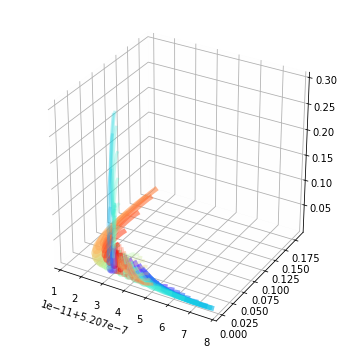

In [18]:
epoch = 'go1'
rule_set = [rule[:-4]+'go',rule]
ax = prep3D_fig(5,5)
ax = plot_task_trial(ax,m,rule_set[0],epoch,D_backprop,linewidth = 5,linestyle = '-',alpha = .6, c_list_label='out')
ax = plot_task_trial(ax,m,rule_set[1],epoch,D_backprop,linewidth = 3,linestyle = '-',alpha = .3, c_list_label='out')

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/d

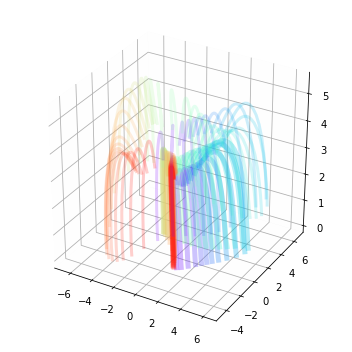

In [21]:
ax = prep3D_fig(5,5)
ax = plot_task_trial(ax,m,rule_set[0],epoch,D_pca,linewidth = 5,linestyle = '-',alpha = .3)
ax = plot_task_trial(ax,m,rule_set[1],epoch,D_pca,linewidth = 3,linestyle = '-',alpha = .2)

In [22]:
def get_task_vec(m,rule,rule_opp,D_use):
    trial_opp = gen_trials_from_model_dir(m,rule_opp)
    _, y_full_opp = gen_hy_from_model_dir(m,trial_opp)

    model = FixedPoint_Model(m)
    with tf.Session() as sess:
        model.restore()
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        # get hparams
        hparams = model.hp
        # create a trial
        trial = generate_trials(rule, hparams, mode='test', noise_on=False, batch_size=40)# get feed_dict
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)  

        leo_hps = {}
        leo = []
        leo = lesion_error_obj(model.cell,sess,model.var_list, **leo_hps) 

        task_vec = make_dedh_all(sess,leo,feed_dict,trial,h_tf,y_full_opp)

    return task_vec

In [26]:
%matplotlib

Using matplotlib backend: MacOSX


In [190]:
##BACKPROP AXES
trial = gen_trials_from_model_dir(m,rule)
h_full, y_full = gen_hy_from_model_dir(m,trial)
_, dedh_all = make_dedh_all(m,rule,y_full,lesion_units_list = lesion_units_list)
pca = PCA(n_components = 3)
fp_pca = pca.fit_transform(dedh_all)
D_backprop = pca.components_.T
    
##PCA
h_all_byepoch, h_all_byrule = make_h_all(m)
X_rule = h_all_byrule[rule]
X_use = np.reshape(X_rule[:],(-1,hparams['n_rnn']))

pca = PCA(n_components = 10)
fp_pca = pca.fit_transform(X_use)
D_pca = pca.components_.T

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/sklearn/decomposition/pca.py:446: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


Overwrite sigma_rec with 0.000
0.0
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


In [23]:
rule = 'fdanti'
rule_opp = rule[:-4]+'go'

trial_opp = gen_trials_from_model_dir(m,rule_opp)
_, y_opp = gen_hy_from_model_dir(m,trial_opp)
task_vec_backprop, _ = make_dedh_all(m,rule,y_opp)

trial = gen_trials_from_model_dir(m,rule)
_, target = gen_hy_from_model_dir(m,trial)
lesion_vec_backprop, _ = make_dedh_all(m,rule,target,lesion_units_list = lesion_units_list)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/d

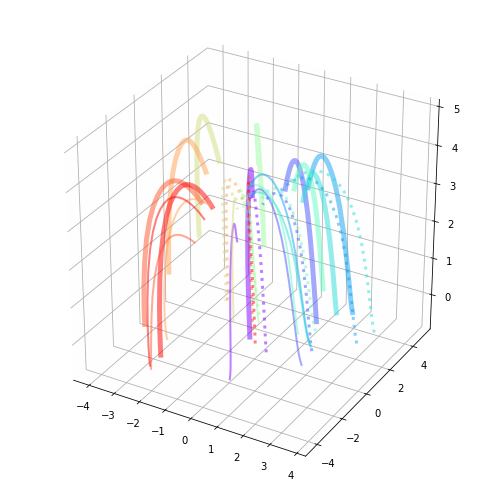

In [24]:
ax = prep3D_fig(7,7)
trial = gen_trials_from_model_dir(m,rule)
h_full, y_full = gen_hy_from_model_dir(m,trial)
c_list = trial.stim_locs[:,0]
trial_set = range(0,80,8)
cmap = plt.get_cmap('rainbow')

al = .5

D_use = D_pca

# x = np.transpose(h_full[:,trial_set,:],(1,0,2))
# plot_N3D(x,D_pca.T,c_list[trial_set],linewidth = 5, linestyle = '-',alpha = .5)

ax = plot_task_trial(ax,m,rule,epoch,D_use,linewidth = 5,linestyle = '-',alpha = al,
                     lesion_units_list = [], trial_set = trial_set)

for x in range(0,40,4):
    c = cmap(x/40)#cmap(c_list[trial_set][x]/(2*np.pi))
    vec_dot = np.dot(lesion_vec_backprop[x],D_use)
    ax.plot3D(vec_dot[:,0],vec_dot[:,1],vec_dot[:,2],'-',c = c, linewidth = 6, alpha = .5)
    ax.plot3D(vec_dot[:,0],vec_dot[:,1],vec_dot[:,2],'-',c = 'k', linewidth = 2, alpha = .5)

ax = plot_task_trial(ax,m,rule_opp,epoch,D_use,linewidth = 3,linestyle = ':',alpha = al, trial_set = trial_set)
ax = plot_task_trial(ax,m,rule,epoch,D_use,linewidth = 2,linestyle = '-',alpha = al,
                     lesion_units_list = lesion_units_list, trial_set = trial_set)
        
plt.show()

In [25]:
epoch = 'go1'
trial_opp = gen_trials_from_model_dir(m,rule_opp)
h_full_opp, y_full_opp = gen_hy_from_model_dir(m,trial_opp)

trial = gen_trials_from_model_dir(m,rule)
h_full, y_full = gen_hy_from_model_dir(m,trial)
h_lesion, y_lesion = gen_hy_from_model_dir(m,trial,lesion_units_list = lesion_units_list)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/d

In [26]:
ind = trial.epochs[epoch][0]
opp_ind = trial_opp.epochs[epoch][0]
origin = np.zeros((np.shape(h_full[[ind,],:,:])))
h_ref = h_full[[trial.epochs[epoch][0],],:,:]
trial_diff = np.concatenate((h_full_opp[[opp_ind,],:,:],h_ref))
lesion_diff = np.concatenate((h_lesion[[ind,],:,:],h_ref))

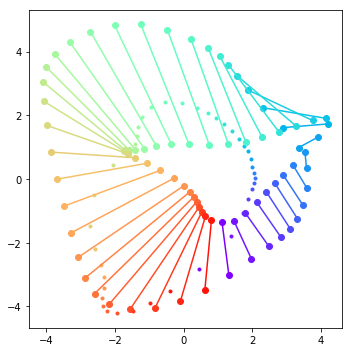

In [27]:
fig = plt.figure(figsize=(5,5),tight_layout=True,facecolor='white')
for b in range(0,np.shape(trial_diff)[1],2):
    trial_diff_pca = np.dot(trial_diff[:,b,:],D_pca)
    plt.plot(trial_diff_pca[:,0],trial_diff_pca[:,1],'-',c = cmap(b/np.shape(trial_diff)[1]))
    
    h_opp_pca = np.dot(h_full_opp[[opp_ind,],b,:],D_pca)
    plt.plot(h_opp_pca[:,0],h_opp_pca[:,1],'o',c = cmap(b/np.shape(trial_diff)[1]))
    
    h_pca = np.dot(h_full[[ind,],b,:],D_pca)
    plt.plot(h_pca[:,0],h_pca[:,1],'o',c = cmap(b/np.shape(trial_diff)[1]))
    
    h_lesion_pca = np.dot(h_lesion[[ind,],b,:],D_pca)
    plt.plot(h_lesion_pca[:,0],h_lesion_pca[:,1],'.',c = cmap(b/np.shape(trial_diff)[1]))

In [162]:
np.shape(lesion_vec)

(256,)

In [164]:
fig = plt.figure(figsize=(5,5),tight_layout=True,facecolor='white')
for b in range(0,np.shape(trial_diff)[1],2):
    
    lesion_diff_pca = np.dot(lesion_diff[:,b,:],D_pca)
    plt.plot(lesion_diff_pca[:,0],lesion_diff_pca[:,1],'-',c = cmap(b/np.shape(trial_diff)[1]))
    
    lesion_backprop_pca = np.dot(lesion_vec_backprop[int(b/2),:,:],D_pca)
    plt.plot(lesion_backprop_pca[:,0],lesion_backprop_pca[:,1],'-',c = cmap(b/np.shape(trial_diff)[1]))
    
    h_pca = np.dot(h_full[[ind,],b,:],D_pca)
    plt.plot(h_pca[:,0],h_pca[:,1],'o',c = cmap(b/np.shape(trial_diff)[1]))
    
    h_lesion_pca = np.dot(h_lesion[[ind,],b,:],D_pca)
    plt.plot(h_lesion_pca[:,0],h_lesion_pca[:,1],'.',c = cmap(b/np.shape(trial_diff)[1]))

In [159]:
sa = np.zeros(40)
for b in range(40):

    lesion_vec = lesion_diff[1,b*2,:] - lesion_diff[0,b*2,:]
    lesion_vec_backprop_sing = lesion_vec_backprop[b,1,:] - lesion_vec_backprop[b,0,:]

    unit_vector_1 = lesion_vec / np.linalg.norm(lesion_vec)
    unit_vector_2 = trial_vec / np.linalg.norm(trial_vec)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(dot_product)

    sa[b] = np.rad2deg(angle)

In [160]:
fig = plt.figure(figsize=(5,5),tight_layout=True,facecolor='white')
plt.hist(sa)
plt.show()

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


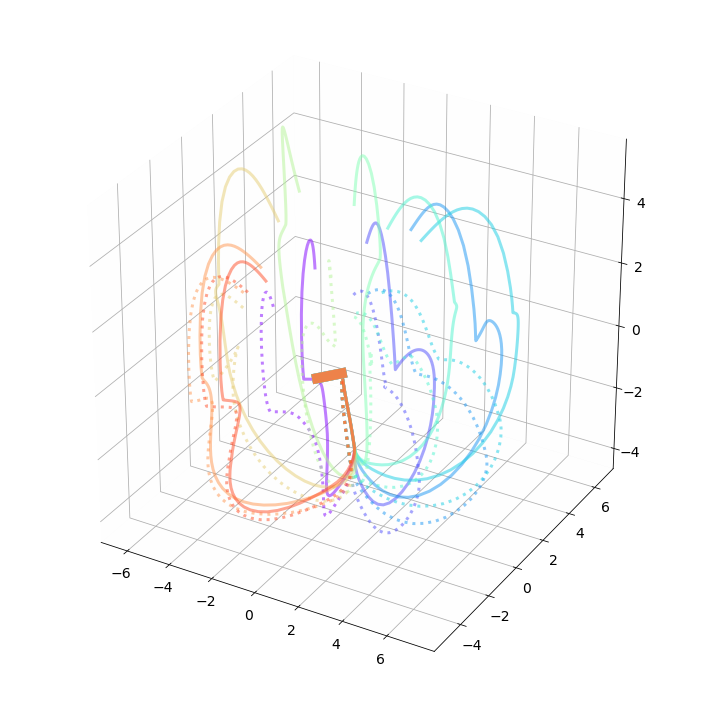

In [24]:
rule = 'delayanti'
cmap = plt.get_cmap('rainbow')

rule_opp = 'delayanti'
trial_opp = gen_trials_from_model_dir(m,rule_opp)
h_full_opp, y_full_opp = gen_hy_from_model_dir(m,trial_opp)
D_use = D_pca

model = FixedPoint_Model(m)
with tf.Session() as sess:
    model.restore()
    model.lesion_units(sess, lesion_units_list)
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    # create a trial
    trial = generate_trials(rule, hparams, mode='test', noise_on=False, batch_size=40)# get feed_dict
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_lesion, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)  
    
    leo_hps = {}
    leo = []
    leo = lesion_error_obj(model.cell,sess,model.var_list, **leo_hps) 
    
    ax = init_plot_backwards(h_full_opp,h_lesion,D_use)
    
    for t in range(0,80,8):
    
        inputs = np.squeeze(trial.x[:,t,:])
        initial_states = h_lesion[:,t,:]

        h_lesion_tf, F, y_hat = leo._grab_RNN(initial_states, inputs)
        cost_lsq = tf.reduce_mean(tf.square((y_full_opp[-10:,t,:] - y_hat[-10:,:])))

        dedh = tf.gradients(cost_lsq, h_lesion_tf)

        dedh_tf = sess.run(dedh, feed_dict=feed_dict)

        ax = plot_backwards(ax,h_full_opp,D_use,task_vec,t)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


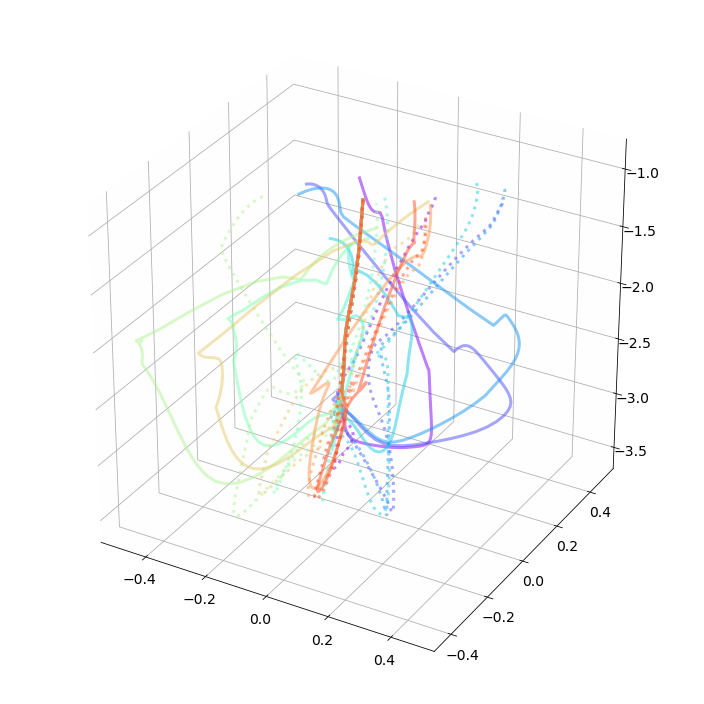

In [25]:
cmap = plt.get_cmap('rainbow')

D = D_backprop
trial = gen_trials_from_model_dir(m,rule)
h_full, y_full = gen_hy_from_model_dir(m,trial)

model = FixedPoint_Model(m)
with tf.Session() as sess:
    model.restore()
    model.lesion_units(sess, lesion_units_list)
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    # create a trial
    trial = generate_trials(rule, hparams, mode='test', noise_on=False, batch_size=40)# get feed_dict
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)  
    
    leo_hps = {}
    leo = []
    leo = lesion_error_obj(model.cell,sess,model.var_list, **leo_hps) 
    
    ax = init_plot_backwards(h_full,h_tf,D)
    
    for t in range(0,80,8):
    
        inputs = np.squeeze(trial.x[:,t,:])
        initial_states = h_tf[:,t,:]

        h_lesion, F, y_hat = leo._grab_RNN(initial_states, inputs)
        cost_lsq = tf.reduce_mean(tf.square((y_full[-10:,t,:] - y_hat[-10:,:])))

        dedy = tf.gradients(cost_lsq, y_hat)
        dydF = tf.gradients(y_hat, F)
        dFdh = tf.gradients(F, h_lesion)
        dedh = tf.gradients(cost_lsq, h_lesion)

        dedh_tf,dFdh_tf,dydF_tf,cost_lsq_tf = sess.run([dedh,dFdh,dydF,cost_lsq], feed_dict=feed_dict)

#         ax = plot_backwards(ax,h_full,D,dedh_tf,t)
        
# ax.set_xlim(-10, 10)
# ax.set_ylim(-10, 10)
# ax.set_zlim(-10, 10)
    

In [211]:
from scipy.linalg import subspace_angles
sa = np.rad2deg(subspace_angles(D_backprop,w_out[:,1:]))

In [212]:
sa

array([6.716011, 4.768892], dtype=float32)

In [ ]:

#     # def gradient_check(x, theta, eps = 1e-7):
    
# #     thetaplus = theta+eps
# #     thetaminus = theta-eps

# #     J_plus = fwdprop(x, thetaplus)
# #     J_minus = fwdprop(x, thetaminus)

# #     gradapprox = (J_plus - J_minus)/(2*eps)

# #     grad = backprop(x,theta)

# #     numerator = LA.norm(grad - gradapprox)
# #     denominator = LA.norm(grad) + LA.norm(gradapprox)
# #     difference = numerator/denominator

# #     return difference


In [23]:
#NUMERICAL CHECK GRADIENT
eps = 1e-7
n_deriv = 0
t = 10
t_ind = 103
model = FixedPoint_Model(m)
with tf.Session() as sess:
    model.restore()
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    # create a trial
    trial = generate_trials(rule, hparams, mode='test', noise_on=False, batch_size=40)# get feed_dict
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron) 
    inputs = np.squeeze(trial.x[:,t,:])
    initial_states = h_tf[:,t,:]

    y_full = trial.y[:,t,:]

    ##backprop
    leo_hps = {}
    leo = []
    leo = lesion_error_obj(model.cell,sess,model.var_list, **leo_hps) 

    h_lesion, F, y_hat = leo._grab_RNN(initial_states, inputs)
    cost_lsq = tf.reduce_mean(tf.square((y_full - y_hat)))

    grad = tf.gradients(cost_lsq, h_lesion)

    grad_tf= sess.run(grad, feed_dict=feed_dict)
    grad_ind = grad_tf[0][t_ind,n_deriv]

    ##fwdprop
    x = inputs[1:,:]
    h0 = initial_states[0,:]
    h_t = vanilla_run_with_h0(params, x, h0, hparams)
    w_out = params[2]
    b_out = params[3]

    N = np.shape(h_tf)[2]
    diff_vec = np.zeros(N)
    diff_vec[n_deriv] = eps
    thetaplus = h_t+diff_vec
    thetaminus = h_t-diff_vec

    y_plus = np.dot(thetaplus, w_out) + b_out
    J_plus = np.mean(np.square((y_full[:t_ind,:] - y_plus[:t_ind,:])))

    y_minus = np.dot(thetaminus, w_out) + b_out
    J_minus = np.mean(np.square((y_full[:t_ind,:] - y_minus[:t_ind,:])))

    gradapprox = (J_plus - J_minus)/(2*eps)

    numerator = LA.norm(grad_ind - gradapprox)
    denominator = LA.norm(grad_ind) + LA.norm(gradapprox)
    difference = numerator/denominator

print(numerator,denominator,difference)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0
9.839091243635245e-06 1.1867035235924028e-05 0.8291111510185992


In [ ]:
    
# def plot_FP_jitter_3D(ax,m,D_use,rule,t_num,fp_epoch,sorted_fps,fp_inds,eig_decomps,
#                    xlabel = 'FP set PC1',ylabel = 'FP set PC2',rand_step_coef = 0.1,n_steps = 100,
#                    lw = 3,al = .6,linestyle = '-',n_jit = 0,c = 'k'):

#     cmap=plt.get_cmap('rainbow')
        
#     model = FixedPoint_Model(m)
#     with tf.Session() as sess:
#         model.restore()
#         model._sigma=0
#         hparams = model.hp
#         alpha = hparams['dt']/hparams['tau']
#         var_list = model.var_list
#         params = [sess.run(var) for var in var_list]

#         trial = generate_trials(rule, hparams, mode='test',noise_on=False)
#         feed_dict = tools.gen_feed_dict(model, trial, hparams)
#         h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
#         T,S,N = np.shape(h_tf)
#         T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing
#         x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],n_steps,1)
        
#         for fp_ind in fp_inds:
#             for jit in range(n_jit):
#                 h0 = sorted_fps[fp_ind,:] + rand_step_coef*npr.randn(N)
#                 h_t = vanilla_run_with_h0(params, x_t, h0, hparams)
#                 jitter = np.dot(h_t,D_use)
#                 ax.plot3D(jitter[:,0],jitter[:,1],jitter[:,2],'-',c = 'k',linewidth = .1)


In [11]:
# ########## X TASK ###########
# fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')
# D_use = D_pca

# for offset in [180,]:#range(0,360,36):# 144
#     t_set = [(offset)%360, (offset+180)%360]
#     trial_num = [int(offset/4.5),int(offset/4.5)]
#     trial_set = range(0,80,8)

#     rule_set = [rule,]
#     epoch_set = ['go1','go1']
#     step_file = 'interp_tasks'
#     linestyle = ['-','--']
#     n_interp = 20

#     trial_str = '_'.join(str(round(t,2)) for t in t_set[:len(rule_set)])
#     rule_str = '_'.join(str(r) for r in rule_set)
#     epoch_str = '_'.join(str(r) for r in epoch_set[:len(rule_set)])

#     cmap_grad = plt.get_cmap('plasma')
#     cmap_discrete = ['darkorchid','orange','m']
#     ax = fig.add_subplot(111, projection='3d')
#     w_color = .005
#     ax.w_xaxis.set_pane_color ((w_color, w_color, w_color, w_color))
#     ax.w_yaxis.set_pane_color ((w_color, w_color, w_color, w_color))
#     ax.w_zaxis.set_pane_color ((w_color, w_color, w_color, w_color))

#     for ri in range(len(rule_set)):
#         rule = rule_set[ri]
#         trial = gen_trials_from_model_dir(m,rule,noise_on = False)
#         epoch = epoch_set[ri]

#         #load fixed points
#         f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(t_set[ri])+'.0.npz')
#         fp_struct = np.load(f)
#         sorted_fps = fp_struct['xstar']
#         fp_inds = range(len(sorted_fps))
#         eig_decomps = comp_eig_decomp(fp_struct['J_xstar'])
        
#         #plot FPs
#         fp_project = np.dot(sorted_fps,D_use)
#         stable_fps = [np.max(eig_decomps[fp_ind]['evals'])<1 for fp_ind in range(len(eig_decomps))]
#         stable_fps_arg = list(compress(range(len(stable_fps)), stable_fps)) 

#         ax.plot3D(fp_project[:,0],fp_project[:,1],fp_project[:,2],'o',c = cmap_discrete[ri],
#                  markersize = 20, markerfacecolor = 'none', alpha = 1,linewidth = 5)
#         ax.plot3D(fp_project[stable_fps_arg,0],fp_project[stable_fps_arg,1],fp_project[stable_fps_arg,2],
#                    'o',c = cmap_discrete[ri],markersize = 20, alpha = 1,linewidth = 5)

#         #plot local dynamics around FPs
#         plot_FP_jitter_3D(ax,m,D_use,rule,trial_num[0],epoch,sorted_fps,fp_inds,eig_decomps,
#                rand_step_coef = 0.1, al = 1, linestyle = linestyle, n_steps = 300, 
#                    n_jit = 1,c = cmap_discrete[ri])

#         #plot evolution of hidden state
#         ax = plot_task_trial(ax,m,rule_set[ri],epoch_set[ri],D_use,linewidth = 2*ri+1,linestyle = '-',alpha = .6)
        
#     #lesion fp
# #     f = os.path.join(m,'lesion_fps','tf_fixed_pts_lesion'+str(cluster+1),rule,epoch+'_'+str(t_set[ri])+'.0.npz')
# #     fp_struct = np.load(f)
# #     sorted_fps = fp_struct['xstar']
# #     fp_inds = range(len(sorted_fps))
# #     eig_decomps = comp_eig_decomp(fp_struct['J_xstar'])

# #     #plot FPs
# #     fp_project = np.dot(sorted_fps,D_use)
# #     stable_fps = [np.max(eig_decomps[fp_ind]['evals'])<1 for fp_ind in range(len(eig_decomps))]
# #     stable_fps_arg = list(compress(range(len(stable_fps)), stable_fps)) 

# #     ax.plot3D(fp_project[:,0],fp_project[:,1],fp_project[:,2],'o',c = cmap_discrete[ri+1],
# #              markersize = 20, markerfacecolor = 'none', alpha = 1,linewidth = 5)
# #     ax.plot3D(fp_project[stable_fps_arg,0],fp_project[stable_fps_arg,1],fp_project[stable_fps_arg,2],
# #                'o',c = cmap_discrete[ri+1],markersize = 20, alpha = 1,linewidth = 5)
    
#     ax = plot_task_trial(ax,m,rule_set[ri],epoch,D_use,linewidth = 3,linestyle = '--',alpha = .6,
#                          lesion_units_list = lesion_units_list)

        
#     tit = '1 TASK '+rule_str+'_'+epoch_str+'_'+trial_str
#     ax.text2D(0.05, 0.95, tit, transform=ax.transAxes)
#     ax.set_xlabel(axes_label1,fontsize = 18)
#     ax.set_ylabel(axes_label2,fontsize = 18)
#     ax.set_zlabel(axes_label3,fontsize = 18)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)